# Speeding up pvfactors

This post is an example of identifying bottlenecks in numerical python code and benchmarking possible alternatives.  Specifically, it shows some of the timings I did for the [SunPower/pvfactors#140](https://github.com/SunPower/pvfactors/pull/140) pull request to the pvfactors bifacial PV simulation package.

The function of interest is `pvfactors.engine.PVEngine.run_full_mode`, which (as of pvfactors version 1.5.2) doesn't run as fast as I'd like it to run, especially for large simulations (many PV rows and many timestamps).

## Identifying the bottlenecks

There's a lot going on under the hood in `run_full_mode`, so let's start by using `pyinstrument` to figure out what parts of the code are taking up the most time.

In [1]:
import warnings
warnings.filterwarnings('ignore', message='Setting custom attributes')
warnings.filterwarnings('ignore', message='invalid value')
warnings.filterwarnings('ignore', message='divide by zero')

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix, csr_matrix
import scipy
import matplotlib.pyplot as plt
import time

import pvlib
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

from pyinstrument import Profiler

In [3]:
def make_engine():
    times = pd.date_range('2019-06-01 08:00', periods=500, freq='1min', tz='Etc/GMT+5')
    location = pvlib.location.Location(40, -80)
    solpos = location.get_solarposition(times)
    irrad = location.get_clearsky(times)
    dniet = pvlib.irradiance.get_extra_radiation(times)
    sat = pvlib.tracking.singleaxis(solpos.zenith, solpos.azimuth, gcr=0.5, backtrack=True)
    axis_azimuth = 180
    n_pvrows = 11

    index_observed_pvrow = n_pvrows//2

    fit_kwargs = dict(solar_zenith=solpos.zenith, solar_azimuth=solpos.azimuth,
                      surface_tilt=sat.surface_tilt, surface_azimuth=sat.surface_azimuth,
                      timestamps=times, DNI=irrad.dni, DHI=irrad.dhi, albedo=0.2)

    pvarray_parameters = {
        'n_pvrows': n_pvrows,
        'axis_azimuth': 180,
        'pvrow_height': 3,
        'pvrow_width': 4,
        'gcr': 0.5
    }

    pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
    eng = PVEngine(pvarray)
    eng.fit(**fit_kwargs)
    return eng

In [4]:
engine = make_engine()

profiler = Profiler()
profiler.start()
engine.run_full_mode()
profiler.stop()
profiler.print(show_all=True)


  _     ._   __/__   _ _  _  _ _/_   Recorded: 11:36:25  Samples:  3674
 /_//_/// /_\ / //_// / //_'/ //     Duration: 7.835     CPU time: 16.020
/   _/                      v4.1.1

Program: /home/kevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/kevin/.local/share/jupyter/runtime/kernel-2a6aef99-d520-43ed-8223-742e139e8e85.json

7.835 run_code  IPython/core/interactiveshell.py:3288
└─ 7.835 <module>  <ipython-input-4-07b716f7020c>:5
   └─ 7.830 run_full_mode  pvfactors/engine.py:177
      ├─ 3.330 build_ts_vf_matrix  pvfactors/viewfactors/calculator.py:69
      │  └─ 3.281 vf_pvrow_gnd_surf  pvfactors/viewfactors/vfmethods.py:14
      │     ├─ 2.939 vf_pvrow_surf_to_gnd_surf_obstruction_hottel  pvfactors/viewfactors/vfmethods.py:105
      │     │  ├─ 2.400 _vf_hottel_gnd_surf  pvfactors/viewfactors/vfmethods.py:473
      │     │  │  ├─ 2.286 _hottel_string_length  pvfactors/viewfactors/vfmethods.py:537
      │     │  │  │  ├─ 1.242 _angle_with_x_axis  pvfacto

So right off the bat, we know that the `vf_pvrow_gnd_surf`, `inv`, and `build_ts_vf_aoi_matrix` steps are the main culprits.  I plan to look at speeding up the two viewfactor calculations as well, but for today we'll just focus on `inv`.

## Benchmarking Alternatives

Despite being mathematically convenient, using explicit matrix inversion to solve a linear system is notoriously inefficient.  If you were to solve a linear system by hand, you wouldn't invert the matrix, you'd probably do something like [Gaussian elimination](https://en.wikipedia.org/wiki/Gaussian_elimination).  Humans and computers are obviously apples and oranges, but in this case it turns out to not be a bad analogy: [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition) with substitution is not so different from Gaussian elimination and is a common numerical approach to solving linear systems.  Indeed [DGESV](http://www.netlib.org/lapack/explore-html/d7/d3b/group__double_g_esolve_ga5ee879032a8365897c3ba91e3dc8d512.html) (**D**ouble-precision **Ge**neral matrix **S**ol**V**e, the LAPACK routine `np.linalg.solve` calls under the hood, for double-precision floats anyway) uses LU decomposition.  So switching from explicit inversion to a decomposition-based solver may be a tasty low-hanging fruit.

Another thing I noticed is that, especially for large simulations, the system being solved tends to be quite [sparse](https://en.wikipedia.org/wiki/Sparse_matrix) (often >90% zeros).  In that case using a dense solver like `DGESV` is silly and a sparse solver may be an improvement.  Scipy has some sparse solvers, but as of this writing they are 2-D only, so an irksome in-python iteration over the third dimension is necessary here.  In the future hopefully they will be made N-D ([ref](https://docs.scipy.org/doc/scipy/reference/sparse.html#module-scipy.sparse)).  A complication is that scipy provides several sparse matrix formats; it's not obvious to me which one will perform best here, so we'll try a couple.  It's also worth pointing out that non-scipy sparse solvers exist, e.g. [sparse](https://sparse.pydata.org/en/stable/), but I've not investigated them here.

For fun, the below code also tries out a sparse explicit inversion.

In [5]:
def inv_einsum(a_mat, irradiance_mat):
    # the approach used in pvfactors 1.5.2
    inv_a_mat = np.linalg.inv(a_mat)
    q0 = np.einsum('ijk,ki->ji', inv_a_mat, irradiance_mat)
    return q0

def solve(a_mat, irradiance_mat):
    # using LAPACK's (actually, OpenBLAS in this case) DGESV routine
    q0 = np.linalg.solve(a_mat, irradiance_mat.T).T
    return q0

# helper functions to make it easy to try the same approach w/ different sparse matrix classes

def make_scipy_sparse_inv(sparse_matrix_class):
    # sparse inv + einsum
    def inv_einsum(a_mat, irradiance_mat):
        inv_as = []
        for a_mat_2d in a_mat:
            a_sparse = sparse_matrix_class(a_mat_2d)
            inv_a = scipy.sparse.linalg.inv(a_sparse).toarray()
            inv_as.append(inv_a)
        inv_a_mat = np.stack(inv_as)
        q0 = np.einsum('ijk,ki->ji', inv_a_mat, irradiance_mat)
        return q0
    
    inv_einsum.__name__ = "sparse_inv_einsum_" + sparse_matrix_class.__name__
    return inv_einsum

def make_sparse_solver(sparse_matrix_class):
    # sparse linear solve
    def spsolve(a_mat, irradiance_mat):
        q0s = []
        for a_mat_2d, irradiance_1d in zip(a_mat, irradiance_mat.T):
            a_sparse = sparse_matrix_class(a_mat_2d)
            irradiance_sparse = sparse_matrix_class(irradiance_1d).T
            q0 = scipy.sparse.linalg.spsolve(a_sparse, irradiance_sparse)
            q0s.append(q0)
        q0 = np.stack(q0s).T
        return q0

    spsolve.__name__ = "spsolve_" + sparse_matrix_class.__name__
    return spsolve

scipy_csc_matrix_inv = make_scipy_sparse_inv(csc_matrix)
scipy_csr_matrix_inv = make_scipy_sparse_inv(csr_matrix)
scipy_csc_matrix_spsolve = make_sparse_solver(csc_matrix)
scipy_csr_matrix_spsolve = make_sparse_solver(csr_matrix)

functions = [inv_einsum, solve,
             scipy_csc_matrix_inv, scipy_csr_matrix_inv,
             scipy_csc_matrix_spsolve, scipy_csr_matrix_spsolve]

Normally I'd just make up some dummy data for testing purposes, but since in this case we're trying to tailor the code to match the specific sparseness characteristics of real pvfactors simulations, I've dumped a system from a real simulation to disk to use here.

In [6]:
import pickle

# matrices extracted from a simulation with n_pvrows=11 and 500 timestamps
with open('a_mat', 'rb') as f:
    a_mat = pickle.load(f)
with open('irradiance_mat', 'rb') as f:
    irradiance_mat = pickle.load(f)
    irradiance_mat[np.isnan(irradiance_mat)] = 0

print(a_mat.shape, irradiance_mat.shape)
# show sparseness:
print(np.mean(a_mat==0), np.mean(irradiance_mat==0))

(500, 321, 321) (321, 500)
0.9773401073359148 0.44277258566978195


First things first, let's make sure the alternatives give the right answer:

In [7]:
q0 = inv_einsum(a_mat, irradiance_mat)
data = []
for function in functions:
    print(function.__name__)
    %time q0_test = function(a_mat, irradiance_mat)
    data.append({
        'function': function.__name__,
        'max abs error': np.nanmax(np.abs(q0_test - q0)),
        'nan equal': np.all(np.isnan(q0) == np.isnan(q0_test))
    })
    print()
pd.DataFrame(data)

inv_einsum
CPU times: user 8.57 s, sys: 2.26 s, total: 10.8 s
Wall time: 2.75 s

solve
CPU times: user 2.5 s, sys: 1.67 s, total: 4.17 s
Wall time: 1.07 s

sparse_inv_einsum_csc_matrix
CPU times: user 47.7 s, sys: 331 ms, total: 48.1 s
Wall time: 47.8 s

sparse_inv_einsum_csr_matrix


/home/kevin/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/kevin/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:216: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


CPU times: user 47.8 s, sys: 20.9 ms, total: 47.8 s
Wall time: 47.8 s

spsolve_csc_matrix
CPU times: user 1.02 s, sys: 11.8 ms, total: 1.03 s
Wall time: 1.03 s

spsolve_csr_matrix
CPU times: user 1.17 s, sys: 143 µs, total: 1.17 s
Wall time: 1.17 s



,function,max abs error,nan equal
0,inv_einsum,0.000000e+00,True
1,solve,8.526513e-14,True
2,sparse_inv_einsum_csc_matrix,1.136868e-13,True
3,sparse_inv_einsum_csr_matrix,1.136868e-13,True
4,spsolve_csc_matrix,1.136868e-13,True
5,spsolve_csr_matrix,1.278977e-13,True


So they all give the right answer.  But looking at the basic `%time` outputs above, the two sparse inversion functions are very slow, so there's no point in including them in the more rigorous timing comparison below.

In [8]:
timings = {}
# don't include the slow-as-molasses sparse inversion functions
for function in [inv_einsum, solve, scipy_csc_matrix_spsolve, scipy_csr_matrix_spsolve]:
    funcname = function.__name__
    timings[funcname] = []
    for _ in range(10):
        st = time.perf_counter()
        _ = function(a_mat, irradiance_mat)
        ed = time.perf_counter()
        timings[funcname].append(ed - st)


Text(0, 0.5, 'Elapsed time [s]')

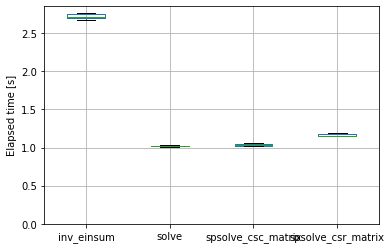

In [9]:
timings = pd.DataFrame(timings)
timings.boxplot(showfliers=False)
plt.ylim(bottom=0)
plt.ylabel('Elapsed time [s]')

In [10]:
timings.median()

inv_einsum            2.714173
solve                 1.020124
spsolve_csc_matrix    1.027375
spsolve_csr_matrix    1.157869
dtype: float64

In [11]:
timings.median() / timings['inv_einsum'].median()

inv_einsum            1.000000
solve                 0.375851
spsolve_csc_matrix    0.378522
spsolve_csr_matrix    0.426601
dtype: float64

So dense and sparse solvers are indeed significantly faster than explicit inversion (for this problem, on this machine, with these package versions, etc etc).  An interesting note is that dense and sparse solvers perform more or less equally here; on another machine with a newer CPU (and newer scipy version) the sparse solver outperformed the dense solver. 